# Deep Progression Unit — PCA Explained Variance Analysis

**Goal:** Prepare features and run PCA explained-variance analysis (scree + cumulative curves) for the **Deep Progression Unit** cohort (Wing Backs/Full Backs + Holding Midfielders + Central Midfielders).

**No clustering or PC naming** — this notebook only outputs variance vs. number of PCs so the analyst can decide the PC count for later analysis.


## 1. Imports & Configuration


In [38]:
import os
import json
from pathlib import Path
import warnings
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import mstats
from statsbombpy import sb

warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Set credentials if available
username = os.getenv('SB_USERNAME')
password = os.getenv('SB_PASSWORD')
creds = {'user': username, 'passwd': password} if username and password else None

if creds:
    print("✓ Credentials loaded successfully")
else:
    print("⚠ No credentials found - using open data access only")

# Configuration
RANDOM_SEED = 42
MIN_MINUTES = 500
MISSING_THRESHOLD = 0.30  # Drop features with ≥30% missing
COVERAGE_360_THRESHOLD = 0.70  # Keep 360 metrics if ≥70% have data
WINSORIZE_LIMITS = (0.01, 0.99)  # 1st and 99th percentiles
COLLINEARITY_THRESHOLD = 0.90  # Drop one feature if |r| ≥ 0.90
NORMALIZATION_MODE = "zscore"  # Options: "zscore" or "l2"
COMPETITION_ID = 73  # Liga MX

np.random.seed(RANDOM_SEED)

# Plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("✓ Imports complete")
print(f"Config: MIN_MINUTES={MIN_MINUTES}, NORMALIZATION_MODE={NORMALIZATION_MODE}, COMPETITION_ID={COMPETITION_ID}")


✓ Credentials loaded successfully
✓ Imports complete
Config: MIN_MINUTES=500, NORMALIZATION_MODE=zscore, COMPETITION_ID=73


## 2. Paths & Logger Setup


In [39]:
# Artifact directory
ARTIFACT_BASE = Path("../data/processed/deep_progression_artifacts")
ARTIFACT_BASE.mkdir(parents=True, exist_ok=True)

def get_season_artifact_dir(season_id: int, season_name: str) -> Path:
    """Create and return season-specific artifact directory."""
    season_dir = ARTIFACT_BASE / str(season_id)
    season_dir.mkdir(parents=True, exist_ok=True)
    return season_dir

def log_message(msg: str, level: str = "INFO"):
    """Simple logger."""
    print(f"[{level}] {msg}")

print(f"✓ Artifact base directory: {ARTIFACT_BASE.absolute()}")


✓ Artifact base directory: c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\deep_progression_artifacts


## 3. Position Definitions


In [40]:
# Deep Progression Unit positions (primary OR secondary)
WING_BACKS_FULL_BACKS = [
    "Left Back",
    "Right Back",
    "Left Wing Back",
    "Right Wing Back"
]

HOLDING_MIDFIELDERS = [
    "Centre Defensive Midfielder",
    "Left Defensive Midfielder",
    "Right Defensive Midfielder"
]

CENTRAL_MIDFIELDERS = [
    "Centre Midfielder",
    "Left Centre Midfielder",
    "Right Centre Midfielder"
]

DEEP_PROGRESSION_POSITIONS = (
    WING_BACKS_FULL_BACKS + 
    HOLDING_MIDFIELDERS + 
    CENTRAL_MIDFIELDERS
)

print(f"✓ Deep Progression Unit positions ({len(DEEP_PROGRESSION_POSITIONS)} total):")
for pos in DEEP_PROGRESSION_POSITIONS:
    print(f"  - {pos}")


✓ Deep Progression Unit positions (10 total):
  - Left Back
  - Right Back
  - Left Wing Back
  - Right Wing Back
  - Centre Defensive Midfielder
  - Left Defensive Midfielder
  - Right Defensive Midfielder
  - Centre Midfielder
  - Left Centre Midfielder
  - Right Centre Midfielder


## 4. Feature Definitions


In [41]:
# Feature groups (all per-90 or ratio metrics)

PASSING_PROGRESSION_FEATURES = [
    # Quality & style
    "player_season_passing_ratio",
    "player_season_pass_length",
    "player_season_pass_length_ratio",
    "player_season_long_ball_ratio",
    "player_season_long_balls_90",
    # Progression
    "player_season_deep_progressions_90",
    "player_season_op_passes_90",
    "player_season_op_passes_into_box_90",
    "player_season_passes_into_box_90",
    "player_season_xgbuildup_90",
    "player_season_xgchain_90",
    # Line-breaking passing (LBP)
    "player_season_lbp_90",
    "player_season_lbp_completed_90",
    "player_season_lbp_ratio",
    "player_season_fhalf_lbp_90",
    "player_season_f3_lbp_90",
    "player_season_obv_lbp_90",
    # Directionality
    "player_season_forward_pass_proportion",
    "player_season_sideways_pass_proportion",
    "player_season_backward_pass_proportion",
    # Under pressure
    "player_season_pressured_passing_ratio",
    "player_season_passes_pressed_ratio",
    "player_season_change_in_passing_ratio",
    "player_season_p_pass_length",
    "player_season_pressured_change_in_pass_length",
    # Value
    "player_season_obv_pass_90",
    "player_season_xa_90",  # Separate, not npxgxa_90
    "player_season_op_xa_90",
    "player_season_sp_xa_90",
]

CARRYING_DRIBBLING_FEATURES = [
    # Volume/success & risk
    "player_season_carries_90",
    "player_season_carry_length",
    "player_season_carry_ratio",
    "player_season_dribbles_90",
    "player_season_dribble_ratio",
    "player_season_failed_dribbles_90",
    "player_season_turnovers_90",
    "player_season_dispossessions_90",
    # Value & outcomes
    "player_season_obv_dribble_carry_90",
    "player_season_positive_outcome_score",
    "player_season_positive_outcome_90",
]

OFFENSIVE_OUTPUT_FEATURES = [
    # Shot creation
    "player_season_key_passes_90",
    "player_season_op_key_passes_90",
    "player_season_sp_key_passes_90",
    "player_season_shots_key_passes_90",
    # Finishing (separate from xA)
    "player_season_np_xg_90",  # Separate, not npxgxa_90
    "player_season_np_xg_per_shot",
    "player_season_npg_90",
    "player_season_conversion_ratio",
    # Box/final third presence
    "player_season_touches_inside_box_90",
    "player_season_crosses_90",
    "player_season_crossing_ratio",
    "player_season_box_cross_ratio",
    "player_season_sp_passes_into_box_90",
    # OBV (offensive/global)
    "player_season_obv_shot_90",
    "player_season_obv_90",
    "player_season_over_under_performance_90",
]

DEFENSIVE_FEATURES = [
    # Separate stats (NOT tackles_and_interceptions_90)
    "player_season_tackles_90",
    "player_season_interceptions_90",
    # Intensity & regains
    "player_season_aggressive_actions_90",
    "player_season_pressures_90",
    "player_season_padj_pressures_90",
    "player_season_pressure_regains_90",
    "player_season_fhalf_pressures_90",
    "player_season_fhalf_pressures_ratio",
    "player_season_ball_recoveries_90",
    "player_season_fhalf_ball_recoveries_90",
    "player_season_defensive_action_90",
    # Duels reliability
    "player_season_challenge_ratio",
    "player_season_dribble_faced_ratio",
    "player_season_dribbled_past_90",
    # Height/locations
    "player_season_average_x_defensive_action",
    "player_season_average_x_pressure",
]

AERIAL_FEATURES = [
    "player_season_aerial_ratio",
    "player_season_aerial_wins_90",
]

AGGRESSIVENESS_FEATURES = [
    "player_season_fouls_90",
    "player_season_fouls_won_90",
    "player_season_yellow_cards_90",
    "player_season_second_yellow_cards_90",
    "player_season_red_cards_90",
]

# 360 metrics (conditional on coverage)
SPACE_360_FEATURES = [
    "player_season_average_space_received_in",
    "player_season_fhalf_ball_receipts_in_space_2_ratio",
    "player_season_f3_ball_receipts_in_space_2_ratio",
    "player_season_lbp_received_90",
    "player_season_fhalf_lbp_received_90",
    "player_season_f3_lbp_received_90",
    "player_season_lbp_to_space_5_received_90",
]

# Combine all base features
BASE_FEATURES = (
    PASSING_PROGRESSION_FEATURES +
    CARRYING_DRIBBLING_FEATURES +
    OFFENSIVE_OUTPUT_FEATURES +
    DEFENSIVE_FEATURES +
    AERIAL_FEATURES +
    AGGRESSIVENESS_FEATURES
)

print(f"✓ Feature groups defined:")
print(f"  - Passing & Progression: {len(PASSING_PROGRESSION_FEATURES)}")
print(f"  - Carrying & Dribbling: {len(CARRYING_DRIBBLING_FEATURES)}")
print(f"  - Offensive Output: {len(OFFENSIVE_OUTPUT_FEATURES)}")
print(f"  - Defensive: {len(DEFENSIVE_FEATURES)}")
print(f"  - Aerial: {len(AERIAL_FEATURES)}")
print(f"  - Aggressiveness: {len(AGGRESSIVENESS_FEATURES)}")
print(f"  - 360 Space (conditional): {len(SPACE_360_FEATURES)}")
print(f"  - Total base features: {len(BASE_FEATURES)}")


✓ Feature groups defined:
  - Passing & Progression: 29
  - Carrying & Dribbling: 11
  - Offensive Output: 16
  - Defensive: 16
  - Aerial: 2
  - Aggressiveness: 5
  - 360 Space (conditional): 7
  - Total base features: 79


In [42]:
# Define all available Liga MX seasons
SEASON_INFO = [
    {"id": 108, "name": "2021/2022", "year": "21/22"},
    {"id": 235, "name": "2022/2023", "year": "22/23"},
    {"id": 281, "name": "2023/2024", "year": "23/24"},
    {"id": 317, "name": "2024/2025", "year": "24/25"}
]

log_message(f"Found {len(SEASON_INFO)} seasons")
for s in SEASON_INFO:
    print(f"  - {s['id']}: {s['name']} ({s['year']})")


[INFO] Found 4 seasons
  - 108: 2021/2022 (21/22)
  - 235: 2022/2023 (22/23)
  - 281: 2023/2024 (23/24)
  - 317: 2024/2025 (24/25)


## 6. Data Fetch & Position Filter


In [43]:
def fetch_season_data(season_id: int) -> pd.DataFrame:
    """Fetch player season stats for a given season."""
    log_message(f"Fetching data for season {season_id}...")
    
    try:
        if creds:
            df = sb.player_season_stats(competition_id=COMPETITION_ID, season_id=season_id, creds=creds)
        else:
            df = sb.player_season_stats(competition_id=COMPETITION_ID, season_id=season_id)
        
        if df is None or df.empty:
            log_message(f"No data for season {season_id}", "WARNING")
            return pd.DataFrame()
        
        log_message(f"Fetched {len(df)} player-season records")
        return df
    except Exception as e:
        log_message(f"Error fetching season {season_id}: {e}", "ERROR")
        return pd.DataFrame()

def filter_deep_progression_positions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter to Deep Progression Unit positions.
    Include if primary OR secondary position matches.
    """
    if df.empty:
        return df
    
    # Check both primary and secondary positions
    primary_match = df["primary_position"].isin(DEEP_PROGRESSION_POSITIONS)
    secondary_match = df["secondary_position"].isin(DEEP_PROGRESSION_POSITIONS)
    
    filtered = df[primary_match | secondary_match].copy()
    
    log_message(f"Position filter: {len(df)} → {len(filtered)} players")
    return filtered

def apply_minutes_filter(df: pd.DataFrame, min_minutes: int = MIN_MINUTES) -> pd.DataFrame:
    """Filter to players with sufficient minutes."""
    if df.empty:
        return df
    
    minutes_col = "player_season_minutes"
    if minutes_col not in df.columns:
        log_message(f"Minutes column not found!", "ERROR")
        return df
    
    filtered = df[df[minutes_col] > min_minutes].copy()
    log_message(f"Minutes filter (>{min_minutes}): {len(df)} → {len(filtered)} players")
    return filtered

def fetch_and_combine_all_seasons() -> pd.DataFrame:
    """
    Fetch all seasons and combine into one dataset.
    Each player-season is a distinct observation.
    """
    all_season_stats = []
    
    for season_info in SEASON_INFO:
        season_id = season_info["id"]
        season_name = season_info["name"]
        
        log_message(f"Fetching season {season_name} (ID: {season_id})...")
        
        # Fetch data
        df = fetch_season_data(season_id)
        if df.empty:
            log_message(f"No data for season {season_id}", "WARNING")
            continue
        
        # Add season info to distinguish same players across seasons
        df['season_id'] = season_id
        df['season_name'] = season_name
        
        # Create unique player-season identifier
        df['player_season_id'] = df['player_id'].astype(str) + '_' + df['season_id'].astype(str)
        
        all_season_stats.append(df)
        log_message(f"  → {len(df)} player records")
    
    # Combine all seasons
    if not all_season_stats:
        raise ValueError("No season data found!")
    
    combined_df = pd.concat(all_season_stats, ignore_index=True)
    log_message(f"\n✓ Combined {len(all_season_stats)} seasons → {len(combined_df)} total player-season records")
    
    return combined_df

# Fetch and combine all seasons
log_message("\n" + "="*80)
log_message("FETCHING ALL SEASONS")
log_message("="*80)
combined_stats = fetch_and_combine_all_seasons()

# Apply filters
log_message("\nApplying filters...")
combined_filtered = filter_deep_progression_positions(combined_stats)
combined_filtered = apply_minutes_filter(combined_filtered)

log_message(f"\n✓ Final cohort: {len(combined_filtered)} player-seasons")
log_message(f"Position distribution:")
print(combined_filtered['primary_position'].value_counts())


[INFO] 
[INFO] FETCHING ALL SEASONS
[INFO] ================================================================================
[INFO] Fetching season 2021/2022 (ID: 108)...
[INFO] Fetching data for season 108...
[INFO] Fetched 603 player-season records
[INFO]   → 603 player records
[INFO] Fetching season 2022/2023 (ID: 235)...
[INFO] Fetching data for season 235...
[INFO] Fetched 591 player-season records
[INFO]   → 591 player records
[INFO] Fetching season 2023/2024 (ID: 281)...
[INFO] Fetching data for season 281...
[INFO] Fetched 623 player-season records
[INFO]   → 623 player records
[INFO] Fetching season 2024/2025 (ID: 317)...
[INFO] Fetching data for season 317...
[INFO] Fetched 636 player-season records
[INFO]   → 636 player records
[INFO] 
✓ Combined 4 seasons → 2453 total player-season records
[INFO] 
Applying filters...
[INFO] Position filter: 2453 → 1157 players
[INFO] Minutes filter (>500): 1157 → 766 players
[INFO] 
✓ Final cohort: 766 player-seasons
[INFO] Position distribu

## 7. Feature Extraction & Validation


In [44]:
def extract_features(df: pd.DataFrame, feature_list: list) -> tuple:
    """
    Extract feature columns from dataframe.
    Returns: (feature_df, missing_features)
    """
    available_features = [f for f in feature_list if f in df.columns]
    missing_features = [f for f in feature_list if f not in df.columns]
    
    if missing_features:
        log_message(f"Missing {len(missing_features)} features from data", "WARNING")
    
    feature_df = df[available_features].copy()
    return feature_df, missing_features

def check_360_coverage(df: pd.DataFrame, feature_list: list) -> tuple:
    """
    Check if 360 metrics have sufficient coverage.
    Returns: (include_360, coverage_ratio)
    """
    available_360 = [f for f in feature_list if f in df.columns]
    
    if not available_360:
        return False, 0.0
    
    # Check non-null coverage across 360 features
    non_null_counts = df[available_360].notna().sum(axis=1)
    rows_with_data = (non_null_counts > 0).sum()
    coverage = rows_with_data / len(df) if len(df) > 0 else 0.0
    
    include_360 = coverage >= COVERAGE_360_THRESHOLD
    
    log_message(f"360 coverage: {coverage:.2%} → {'INCLUDE' if include_360 else 'EXCLUDE'}")
    return include_360, coverage

# Extract features from combined dataset
log_message("\n" + "="*80)
log_message("FEATURE EXTRACTION")
log_message("="*80)

features_df, missing_features = extract_features(combined_filtered, BASE_FEATURES)
log_message(f"Base features: {len(features_df.columns)} / {len(BASE_FEATURES)} available")

# Check 360 coverage
include_360, coverage_360 = check_360_coverage(combined_filtered, SPACE_360_FEATURES)

if include_360:
    space_df, space_missing = extract_features(combined_filtered, SPACE_360_FEATURES)
    features_df = pd.concat([features_df, space_df], axis=1)
    missing_features.extend(space_missing)
    log_message(f"360 metrics added: {len(space_df.columns)} features")

log_message(f"\n✓ Total features extracted: {len(features_df.columns)}")


[INFO] 
[INFO] FEATURE EXTRACTION
[INFO] ================================================================================
[WARNING] Missing 1 features from data
[INFO] Base features: 78 / 79 available
[INFO] 360 coverage: 100.00% → INCLUDE
[INFO] 360 metrics added: 7 features
[INFO] 
✓ Total features extracted: 85


## 8. Missingness Analysis & Feature Dropping


In [45]:
def analyze_missingness(df: pd.DataFrame) -> pd.DataFrame:
    """Compute missingness percentage for each feature."""
    missing_pct = (df.isna().sum() / len(df)).sort_values(ascending=False)
    return missing_pct

def drop_high_missing_features(df: pd.DataFrame, threshold: float = MISSING_THRESHOLD) -> tuple:
    """
    Drop features with missingness >= threshold.
    Returns: (cleaned_df, dropped_features_dict)
    """
    missing_pct = analyze_missingness(df)
    high_missing = missing_pct[missing_pct >= threshold]
    
    if len(high_missing) > 0:
        log_message(f"Dropping {len(high_missing)} features with ≥{threshold:.0%} missing")
        for feat, pct in high_missing.items():
            print(f"  - {feat}: {pct:.1%} missing")
    
    keep_features = [f for f in df.columns if f not in high_missing.index]
    dropped_dict = {feat: f"{pct:.2%} missing" for feat, pct in high_missing.items()}
    
    return df[keep_features].copy(), dropped_dict

# Missingness analysis
log_message("\n" + "="*80)
log_message("MISSINGNESS ANALYSIS")
log_message("="*80)

missing_analysis = analyze_missingness(features_df)
print(f"Top 10 features by missingness:")
print(missing_analysis.head(10))

features_clean, dropped_missing = drop_high_missing_features(features_df)
log_message(f"\n✓ Features after missingness drop: {len(features_clean.columns)}")


[INFO] 
[INFO] MISSINGNESS ANALYSIS
[INFO] ================================================================================
Top 10 features by missingness:
player_season_crossing_ratio                          0.026110
player_season_box_cross_ratio                         0.020888
player_season_np_xg_per_shot                          0.011749
player_season_conversion_ratio                        0.011749
player_season_obv_shot_90                             0.011749
player_season_dribble_ratio                           0.009138
player_season_f3_ball_receipts_in_space_2_ratio       0.002611
player_season_aerial_ratio                            0.001305
player_season_fhalf_ball_receipts_in_space_2_ratio    0.001305
player_season_xgbuildup_90                            0.000000
dtype: float64
[INFO] 
✓ Features after missingness drop: 85


## 9. Imputation


In [46]:
def impute_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Impute remaining missing values with median.
    """
    df_imputed = df.copy()
    
    for col in df_imputed.columns:
        if df_imputed[col].isna().any():
            median_val = df_imputed[col].median()
            n_missing = df_imputed[col].isna().sum()
            df_imputed[col].fillna(median_val, inplace=True)
            log_message(f"Imputed {n_missing} missing values in {col} with median={median_val:.3f}")
    
    return df_imputed

# Imputation
log_message("\n" + "="*80)
log_message("IMPUTATION")
log_message("="*80)

features_imputed = impute_missing(features_clean)
log_message(f"✓ Remaining missing values: {features_imputed.isna().sum().sum()}")


[INFO] 
[INFO] IMPUTATION
[INFO] ================================================================================
[INFO] Imputed 7 missing values in player_season_dribble_ratio with median=0.540
[INFO] Imputed 9 missing values in player_season_np_xg_per_shot with median=0.056
[INFO] Imputed 9 missing values in player_season_conversion_ratio with median=0.040
[INFO] Imputed 20 missing values in player_season_crossing_ratio with median=0.313
[INFO] Imputed 16 missing values in player_season_box_cross_ratio with median=0.250
[INFO] Imputed 9 missing values in player_season_obv_shot_90 with median=-0.011
[INFO] Imputed 1 missing values in player_season_aerial_ratio with median=0.500
[INFO] Imputed 1 missing values in player_season_fhalf_ball_receipts_in_space_2_ratio with median=0.924
[INFO] Imputed 2 missing values in player_season_f3_ball_receipts_in_space_2_ratio with median=0.887
[INFO] ✓ Remaining missing values: 0


## 10. Winsorization


In [47]:
def winsorize_features(df: pd.DataFrame, limits: tuple = WINSORIZE_LIMITS) -> tuple:
    """
    Winsorize each feature to [1st, 99th] percentiles.
    Returns: (winsorized_df, bounds_dict)
    """
    df_wins = df.copy()
    bounds_dict = {}
    
    for col in df_wins.columns:
        # Compute bounds
        lower = df_wins[col].quantile(limits[0])
        upper = df_wins[col].quantile(limits[1])
        
        # Apply winsorization
        df_wins[col] = df_wins[col].clip(lower=lower, upper=upper)
        
        bounds_dict[col] = {"lower": float(lower), "upper": float(upper)}
    
    log_message(f"Winsorized {len(df_wins.columns)} features to [{limits[0]:.2%}, {limits[1]:.2%}] percentiles")
    return df_wins, bounds_dict

# Winsorization
log_message("\n" + "="*80)
log_message("WINSORIZATION")
log_message("="*80)

features_winsorized, winsorize_bounds = winsorize_features(features_imputed)


[INFO] 
[INFO] WINSORIZATION
[INFO] ================================================================================
[INFO] Winsorized 85 features to [1.00%, 99.00%] percentiles


## 11. Normalization


In [48]:
def normalize_zscore(df: pd.DataFrame) -> tuple:
    """
    Z-score normalization: (x - mean) / std
    Returns: (normalized_df, scaler_params)
    """
    df_norm = df.copy()
    scaler_params = {}
    
    for col in df_norm.columns:
        mean_val = df_norm[col].mean()
        std_val = df_norm[col].std()
        
        if std_val > 0:
            df_norm[col] = (df_norm[col] - mean_val) / std_val
        else:
            df_norm[col] = 0.0
            log_message(f"Zero std for {col}, setting to 0", "WARNING")
        
        scaler_params[col] = {"mean": float(mean_val), "std": float(std_val)}
    
    log_message(f"Z-score normalized {len(df_norm.columns)} features")
    return df_norm, scaler_params

def normalize_l2(df: pd.DataFrame) -> tuple:
    """
    Row-wise L2 normalization.
    Returns: (normalized_df, params_dict)
    """
    df_norm = df.copy()
    norms = np.linalg.norm(df_norm.values, axis=1, keepdims=True)
    norms[norms == 0] = 1.0  # Avoid division by zero
    df_norm = pd.DataFrame(
        df_norm.values / norms,
        columns=df_norm.columns,
        index=df_norm.index
    )
    
    log_message(f"L2 normalized {len(df_norm.columns)} features (row-wise)")
    return df_norm, {"mode": "l2"}

def normalize_features(df: pd.DataFrame, mode: str = NORMALIZATION_MODE) -> tuple:
    """
    Normalize features based on mode.
    """
    if mode == "zscore":
        return normalize_zscore(df)
    elif mode == "l2":
        return normalize_l2(df)
    else:
        raise ValueError(f"Unknown normalization mode: {mode}")

# Normalization
log_message("\n" + "="*80)
log_message("NORMALIZATION")
log_message("="*80)

features_normalized, scaler_params = normalize_features(features_winsorized, NORMALIZATION_MODE)
log_message(f"✓ Normalized shape: {features_normalized.shape}")


[INFO] 
[INFO] NORMALIZATION
[INFO] ================================================================================
[INFO] Z-score normalized 85 features
[INFO] ✓ Normalized shape: (766, 85)


## 12. Collinearity Pruning (Optional)


In [49]:
def prune_collinear_features(df: pd.DataFrame, threshold: float = COLLINEARITY_THRESHOLD) -> tuple:
    """
    Drop one feature from pairs with |correlation| >= threshold.
    Prioritize keeping more interpretable features.
    Returns: (pruned_df, dropped_dict)
    """
    corr_matrix = df.corr().abs()
    
    # Upper triangle (avoid double-counting)
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find features to drop
    to_drop = set()
    dropped_dict = {}
    
    for column in upper_tri.columns:
        if column in to_drop:
            continue
        
        high_corr = upper_tri[column][upper_tri[column] >= threshold]
        
        for other_feat in high_corr.index:
            if other_feat not in to_drop:
                # Drop the second feature (simpler heuristic)
                to_drop.add(other_feat)
                dropped_dict[other_feat] = f"Correlated with {column} (r={upper_tri.loc[other_feat, column]:.3f})"
    
    if to_drop:
        log_message(f"Dropping {len(to_drop)} collinear features (|r| ≥ {threshold})")
        for feat, reason in dropped_dict.items():
            print(f"  - {feat}: {reason}")
    else:
        log_message(f"No collinear features found (threshold={threshold})")
    
    keep_features = [f for f in df.columns if f not in to_drop]
    return df[keep_features].copy(), dropped_dict

# Collinearity pruning
log_message("\n" + "="*80)
log_message("COLLINEARITY PRUNING")
log_message("="*80)

features_final, dropped_collinear = prune_collinear_features(features_normalized)
log_message(f"✓ Final features for PCA: {len(features_final.columns)}")


[INFO] 
[INFO] COLLINEARITY PRUNING
[INFO] ================================================================================
[INFO] Dropping 13 collinear features (|r| ≥ 0.9)
  - player_season_xgbuildup_90: Correlated with player_season_xgchain_90 (r=0.924)
  - player_season_lbp_90: Correlated with player_season_lbp_completed_90 (r=0.903)
  - player_season_xa_90: Correlated with player_season_op_xa_90 (r=0.934)
  - player_season_carry_ratio: Correlated with player_season_turnovers_90 (r=0.902)
  - player_season_positive_outcome_score: Correlated with player_season_positive_outcome_90 (r=0.901)
  - player_season_key_passes_90: Correlated with player_season_op_key_passes_90 (r=0.909)
  - player_season_sp_xa_90: Correlated with player_season_sp_key_passes_90 (r=0.950)
  - player_season_sp_key_passes_90: Correlated with player_season_sp_passes_into_box_90 (r=0.903)
  - player_season_aggressive_actions_90: Correlated with player_season_pressures_90 (r=0.927)
  - player_season_fhalf_pressures

## 13. PCA Fitting & Variance Analysis


In [50]:
def fit_pca(df: pd.DataFrame) -> tuple:
    """
    Fit PCA on normalized features (no component limit).
    Returns: (pca_model, explained_var, explained_var_ratio)
    """
    n_components = min(df.shape[0], df.shape[1])  # Max possible components
    
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    pca.fit(df)
    
    explained_var = pca.explained_variance_
    explained_var_ratio = pca.explained_variance_ratio_
    
    log_message(f"PCA fitted: {n_components} components, {explained_var_ratio.sum():.1%} total variance")
    
    return pca, explained_var, explained_var_ratio

def compute_cumulative_variance(explained_var_ratio: np.ndarray) -> np.ndarray:
    """Compute cumulative explained variance."""
    return np.cumsum(explained_var_ratio)

# Fit PCA on combined dataset
log_message("\n" + "="*80)
log_message("PCA FITTING")
log_message("="*80)

pca, explained_var, explained_var_ratio = fit_pca(features_final)
cumulative_var = compute_cumulative_variance(explained_var_ratio)

# Find PCs for variance thresholds
pc_80 = np.where(cumulative_var >= 0.80)[0][0] + 1 if len(np.where(cumulative_var >= 0.80)[0]) > 0 else None
pc_90 = np.where(cumulative_var >= 0.90)[0][0] + 1 if len(np.where(cumulative_var >= 0.90)[0]) > 0 else None
pc_95 = np.where(cumulative_var >= 0.95)[0][0] + 1 if len(np.where(cumulative_var >= 0.95)[0]) > 0 else None

log_message(f"\n✓ PCA Results:")
log_message(f"  - Total components: {len(explained_var_ratio)}")
log_message(f"  - PCs for 80% variance: {pc_80}")
log_message(f"  - PCs for 90% variance: {pc_90}")
log_message(f"  - PCs for 95% variance: {pc_95}")


[INFO] 
[INFO] PCA FITTING
[INFO] ================================================================================
[INFO] PCA fitted: 72 components, 100.0% total variance
[INFO] 
✓ PCA Results:
[INFO]   - Total components: 72
[INFO]   - PCs for 80% variance: 17
[INFO]   - PCs for 90% variance: 28
[INFO]   - PCs for 95% variance: 37


[INFO] 
[INFO] GENERATING VISUALIZATIONS
[INFO] ================================================================================
[INFO] Saved scree plot to ..\data\processed\deep_progression_artifacts\pca_scree.png


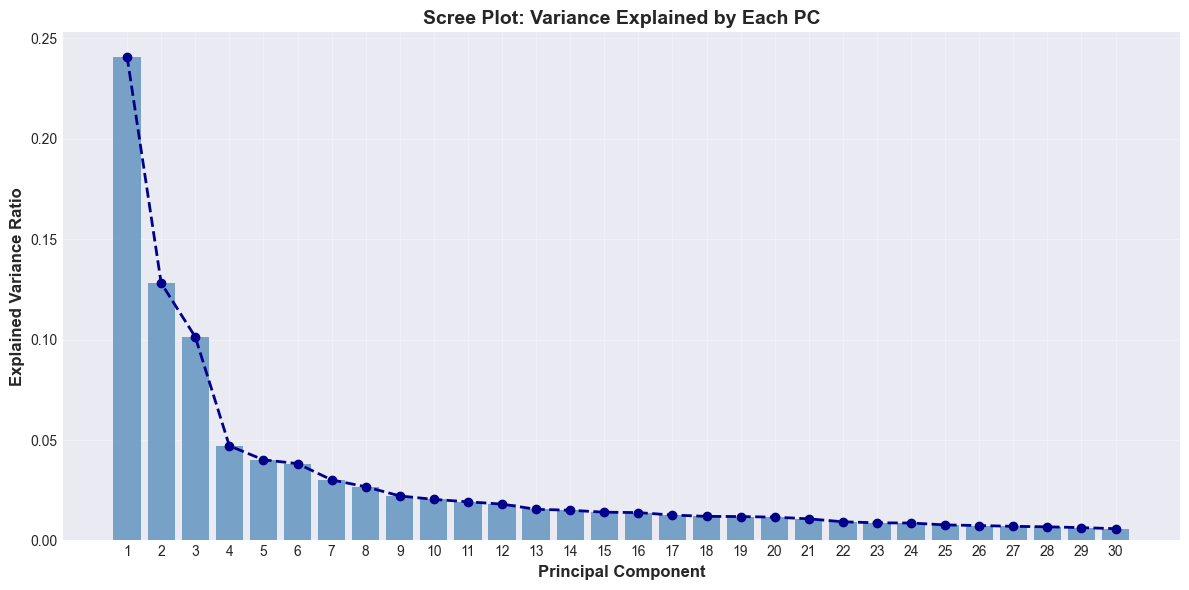

[INFO] Saved cumulative plot to ..\data\processed\deep_progression_artifacts\pca_cumulative.png


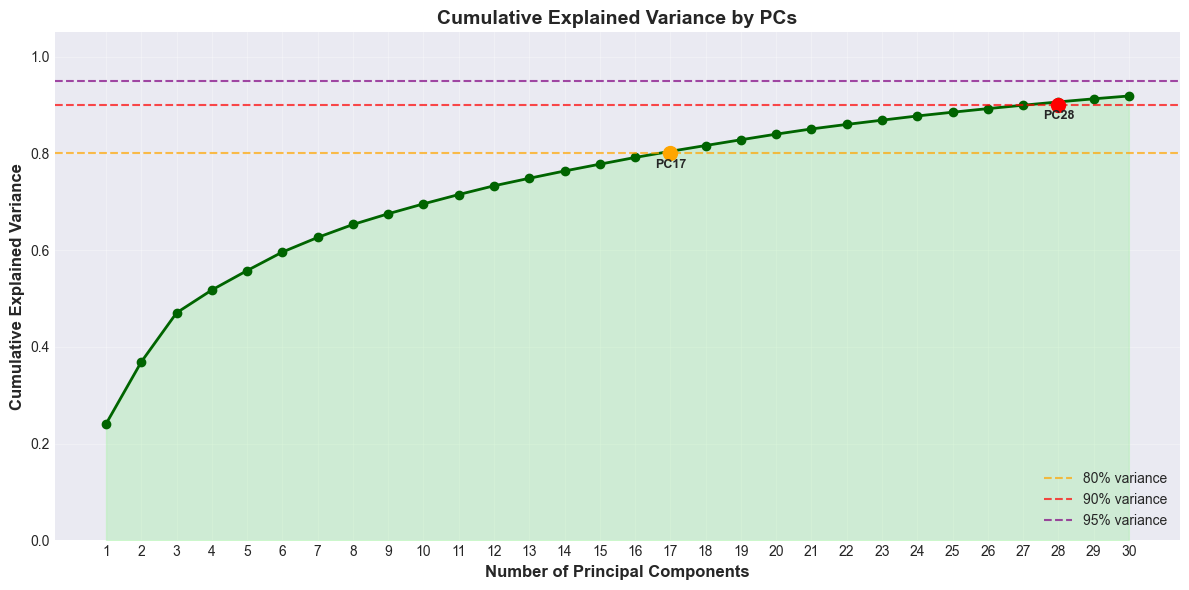

In [51]:
def plot_scree(explained_var_ratio: np.ndarray, max_components: int = 30, save_path: Path = None):
    """
    Create scree plot showing variance explained by each PC.
    """
    n_components = min(max_components, len(explained_var_ratio))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(1, n_components + 1)
    y = explained_var_ratio[:n_components]
    
    ax.bar(x, y, alpha=0.7, color='steelblue')
    ax.plot(x, y, marker='o', linestyle='--', color='darkblue', linewidth=2, markersize=6)
    
    ax.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
    ax.set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
    ax.set_title('Scree Plot: Variance Explained by Each PC', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(x)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved scree plot to {save_path}")
    
    plt.show()

def plot_cumulative(explained_var_ratio: np.ndarray, max_components: int = 30, save_path: Path = None):
    """
    Create cumulative variance plot with threshold lines.
    """
    cumulative = np.cumsum(explained_var_ratio)
    n_components = min(max_components, len(cumulative))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(1, n_components + 1)
    y = cumulative[:n_components]
    
    ax.plot(x, y, marker='o', linestyle='-', color='darkgreen', linewidth=2, markersize=6)
    ax.fill_between(x, y, alpha=0.3, color='lightgreen')
    
    # Threshold lines
    for threshold, label, color in [(0.80, '80%', 'orange'), (0.90, '90%', 'red'), (0.95, '95%', 'purple')]:
        ax.axhline(y=threshold, linestyle='--', color=color, linewidth=1.5, alpha=0.7, label=f'{label} variance')
        
        # Find first PC reaching threshold
        idx = np.where(cumulative >= threshold)[0]
        if len(idx) > 0 and idx[0] < n_components:
            pc_num = idx[0] + 1
            ax.plot(pc_num, threshold, 'o', color=color, markersize=10)
            ax.text(pc_num, threshold - 0.03, f'PC{pc_num}', ha='center', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
    ax.set_title('Cumulative Explained Variance by PCs', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(x)
    ax.set_ylim([0, 1.05])
    ax.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved cumulative plot to {save_path}")
    
    plt.show()

# Generate plots
log_message("\n" + "="*80)
log_message("GENERATING VISUALIZATIONS")
log_message("="*80)

plot_scree(explained_var_ratio, max_components=min(30, len(explained_var_ratio)), save_path=ARTIFACT_BASE / "pca_scree.png")
plot_cumulative(explained_var_ratio, max_components=min(30, len(explained_var_ratio)), save_path=ARTIFACT_BASE / "pca_cumulative.png")


## 15. Save Artifacts


In [55]:
def save_artifacts(
    artifact_dir: Path,
    features_used: list,
    explained_var: np.ndarray,
    explained_var_ratio: np.ndarray,
    dropped_features: dict,
    scaler_params: dict,
    winsorize_bounds: dict,
    include_360: bool,
    coverage_360: float,
    cohort_size: int,
    season_breakdown: dict
):
    """
    Save all artifacts for combined analysis.
    """
    log_message("\n" + "="*80)
    log_message("SAVING ARTIFACTS")
    log_message("="*80)
    
    # 1. Features used
    with open(artifact_dir / "pca_features_used.json", "w", encoding='utf-8') as f:
        json.dump(features_used, f, indent=2)
    log_message("✓ Saved features_used.json")
    
    # 2. Variance arrays
    np.save(artifact_dir / "pca_explained_variance.npy", explained_var)
    np.save(artifact_dir / "pca_explained_variance_ratio.npy", explained_var_ratio)
    log_message("✓ Saved variance arrays")
    
    # 3. Dropped features log
    with open(artifact_dir / "dropped_features_log.json", "w", encoding='utf-8') as f:
        json.dump(dropped_features, f, indent=2)
    log_message("✓ Saved dropped_features_log.json")
    
    # 4. Scaler params
    scaler_output = {
        "normalization_mode": NORMALIZATION_MODE,
        "parameters": scaler_params
    }
    with open(artifact_dir / "scaler_params.json", "w", encoding='utf-8') as f:
        json.dump(scaler_output, f, indent=2)
    log_message("✓ Saved scaler_params.json")
    
    # 5. Winsorize bounds
    with open(artifact_dir / "winsorize_bounds.json", "w", encoding='utf-8') as f:
        json.dump(winsorize_bounds, f, indent=2)
    log_message("✓ Saved winsorize_bounds.json")
    
    # 6. Data quality report
    cumulative = np.cumsum(explained_var_ratio)
    
    # Find PCs for thresholds
    pc_80 = np.where(cumulative >= 0.80)[0][0] + 1 if len(np.where(cumulative >= 0.80)[0]) > 0 else "N/A"
    pc_90 = np.where(cumulative >= 0.90)[0][0] + 1 if len(np.where(cumulative >= 0.90)[0]) > 0 else "N/A"
    pc_95 = np.where(cumulative >= 0.95)[0][0] + 1 if len(np.where(cumulative >= 0.95)[0]) > 0 else "N/A"
    
    # Build variance breakdown for first 10 PCs
    variance_breakdown_lines = []
    num_pcs_to_show = min(10, len(explained_var_ratio))
    for i in range(num_pcs_to_show):
        pc_num = i + 1
        individual_var = explained_var_ratio[i]
        cumulative_var = cumulative[i]
        variance_breakdown_lines.append(f"  - **PC{pc_num}:** {individual_var:.2%} (cumulative: {cumulative_var:.2%})")
    variance_breakdown = "\n".join(variance_breakdown_lines)
    
    # Build season breakdown string
    season_breakdown_lines = []
    for season_id, count in season_breakdown.items():
        season_breakdown_lines.append(f"  - Season {season_id}: {count} player-seasons")
    season_breakdown_str = "\n".join(season_breakdown_lines)
    
    # Calculate feature counts
    base_count = len(BASE_FEATURES)
    space_360_count = len(SPACE_360_FEATURES) if include_360 else 0
    total_extracted = base_count + space_360_count
    
    report = f"""# Data Quality Report: Deep Progression Unit (All Seasons Combined)

## Cohort
- **Total Size:** {cohort_size} player-seasons
- **Seasons:** {len(season_breakdown)} seasons combined
{season_breakdown_str}
- **Positions:** Wing Backs, Full Backs, Holding Midfielders, Central Midfielders
- **Minutes filter:** > {MIN_MINUTES}

## Features
- **Base features:** {base_count}
- **360 metrics:** {"Yes" if include_360 else "No"} (coverage: {coverage_360:.1%})
- **360 features added:** {space_360_count}
- **Total features extracted:** {total_extracted}
- **Features dropped:** {len(dropped_features)}
- **Final features for PCA:** {len(features_used)}

## Preprocessing
- **Missingness threshold:** >={MISSING_THRESHOLD:.0%}
- **Winsorization:** [{WINSORIZE_LIMITS[0]:.1%}, {WINSORIZE_LIMITS[1]:.1%}] percentiles
- **Normalization:** {NORMALIZATION_MODE}
- **Collinearity threshold:** |r| >= {COLLINEARITY_THRESHOLD}

## PCA Results
- **Total components:** {len(explained_var_ratio)}
- **Components for 80% variance:** {pc_80}
- **Components for 90% variance:** {pc_90}
- **Components for 95% variance:** {pc_95}

### Variance Explained by First 10 PCs
{variance_breakdown}

## Dropped Features
"""
    
    if dropped_features:
        for feat, reason in dropped_features.items():
            report += f"- **{feat}:** {reason}\n"
    else:
        report += "- None\n"
    
    with open(artifact_dir / "data_quality_report.md", "w", encoding='utf-8') as f:
        f.write(report)
    log_message("✓ Saved data_quality_report.md")
    
    log_message(f"\n✓ All artifacts saved to {artifact_dir}")

print("✓ Artifact save function defined")


✓ Artifact save function defined


## 16. Save All Artifacts


In [56]:
# Prepare dropped features dict
dropped_features = {
    **{f: "Missing from data" for f in missing_features},
    **{f: "360 coverage insufficient" for f in SPACE_360_FEATURES if not include_360},
    **dropped_missing,
    **dropped_collinear
}

# Get season breakdown
season_breakdown = combined_filtered['season_id'].value_counts().to_dict()

# Save all artifacts
save_artifacts(
    artifact_dir=ARTIFACT_BASE,
    features_used=features_final.columns.tolist(),
    explained_var=explained_var,
    explained_var_ratio=explained_var_ratio,
    dropped_features=dropped_features,
    scaler_params=scaler_params,
    winsorize_bounds=winsorize_bounds,
    include_360=include_360,
    coverage_360=coverage_360,
    cohort_size=len(combined_filtered),
    season_breakdown=season_breakdown
)


[INFO] 
[INFO] SAVING ARTIFACTS
[INFO] ================================================================================
[INFO] ✓ Saved features_used.json
[INFO] ✓ Saved variance arrays
[INFO] ✓ Saved dropped_features_log.json
[INFO] ✓ Saved scaler_params.json
[INFO] ✓ Saved winsorize_bounds.json
[INFO] ✓ Saved data_quality_report.md
[INFO] 
✓ All artifacts saved to ..\data\processed\deep_progression_artifacts


## 17. Final Summary


In [54]:
log_message("\n" + "="*80)
log_message("ANALYSIS COMPLETE!")
log_message("="*80)

log_message(f"\n📊 Final Summary:")
log_message(f"  - Total player-seasons: {len(combined_filtered)}")
log_message(f"  - Seasons: {list(season_breakdown.keys())}")
log_message(f"  - Features used: {len(features_final.columns)}")
log_message(f"  - Features dropped: {len(dropped_features)}")
log_message(f"  - 360 metrics included: {include_360}")
log_message(f"  - Total PCA components: {len(explained_var_ratio)}")
log_message(f"  - PCs for 80% variance: {pc_80}")
log_message(f"  - PCs for 90% variance: {pc_90}")
log_message(f"  - PCs for 95% variance: {pc_95}")
log_message(f"\n✓ All artifacts saved to: {ARTIFACT_BASE.absolute()}")


[INFO] 
[INFO] ANALYSIS COMPLETE!
[INFO] ================================================================================
[INFO] 
📊 Final Summary:
[INFO]   - Total player-seasons: 766
[INFO]   - Seasons: [317, 235, 281, 108]
[INFO]   - Features used: 72
[INFO]   - Features dropped: 14
[INFO]   - 360 metrics included: True
[INFO]   - Total PCA components: 72
[INFO]   - PCs for 80% variance: 17
[INFO]   - PCs for 90% variance: 28
[INFO]   - PCs for 95% variance: 37
[INFO] 
✓ All artifacts saved to: c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\deep_progression_artifacts


## 18. PCA Loadings Analysis (First 7 PCs)

Investigate which features contribute most to each of the first 7 principal components.


In [58]:
def analyze_pc_loadings(pca_model, feature_names, n_pcs=7, top_n=10):
    """
    Analyze and display top loadings for each PC.
    
    Parameters:
    - pca_model: Fitted PCA model
    - feature_names: List of feature names
    - n_pcs: Number of PCs to analyze
    - top_n: Number of top features to show per PC
    """
    log_message("\n" + "="*80)
    log_message(f"LOADINGS ANALYSIS: FIRST {n_pcs} PCs")
    log_message("="*80)
    
    # Get loadings matrix (components)
    loadings = pca_model.components_[:n_pcs, :]
    
    results = {}
    
    for i in range(n_pcs):
        pc_num = i + 1
        pc_loadings = loadings[i, :]
        
        # Create DataFrame of loadings
        loading_df = pd.DataFrame({
            'feature': feature_names,
            'loading': pc_loadings,
            'abs_loading': np.abs(pc_loadings)
        }).sort_values('abs_loading', ascending=False)
        
        results[f'PC{pc_num}'] = loading_df
        
        log_message(f"\n{'='*60}")
        log_message(f"PC{pc_num} - Top {top_n} Features by Absolute Loading")
        log_message(f"{'='*60}")
        
        for idx, row in loading_df.head(top_n).iterrows():
            direction = "+" if row['loading'] > 0 else "-"
            log_message(f"  {direction} {row['feature']:50s} | {row['loading']:+.3f}")
    
    return results

# Analyze loadings
loading_results = analyze_pc_loadings(pca, features_final.columns.tolist(), n_pcs=7, top_n=10)


[INFO] 
[INFO] LOADINGS ANALYSIS: FIRST 7 PCs
[INFO] ================================================================================
[INFO] 
[INFO] PC1 - Top 10 Features by Absolute Loading
[INFO] ============================================================
[INFO]   + player_season_average_x_pressure                   | +0.207
[INFO]   + player_season_shots_key_passes_90                  | +0.205
[INFO]   + player_season_lbp_to_space_5_received_90           | +0.201
[INFO]   + player_season_op_key_passes_90                     | +0.192
[INFO]   + player_season_dispossessions_90                    | +0.191
[INFO]   - player_season_average_space_received_in            | -0.188
[INFO]   + player_season_turnovers_90                         | +0.188
[INFO]   + player_season_fhalf_pressures_90                   | +0.184
[INFO]   + player_season_f3_lbp_received_90                   | +0.183
[INFO]   + player_season_positive_outcome_90                  | +0.176
[INFO] 
[INFO] PC2 - Top 10 Fea

### Visualize Loadings Heatmap


[INFO] Saved loadings heatmap to ..\data\processed\deep_progression_artifacts\pca_loadings_heatmap.png


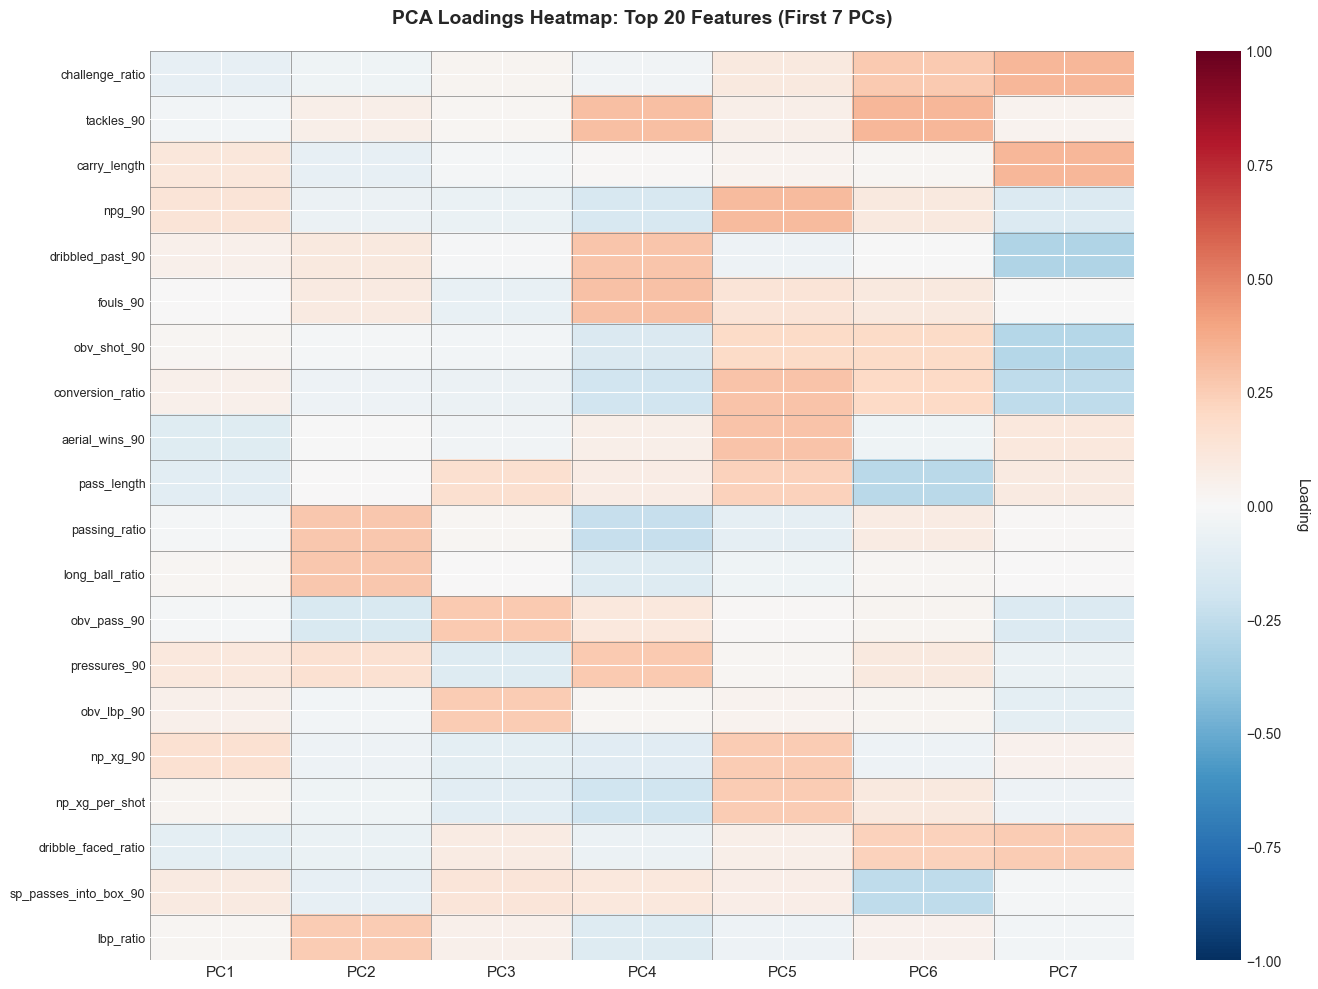

In [59]:
def plot_loadings_heatmap(pca_model, feature_names, n_pcs=7, top_n=15, save_path=None):
    """
    Create a heatmap of loadings for the first n_pcs, showing top_n features per PC.
    """
    # Get loadings
    loadings = pca_model.components_[:n_pcs, :]
    
    # Find top features across all PCs
    abs_loadings = np.abs(loadings)
    max_abs_loadings = abs_loadings.max(axis=0)
    top_feature_indices = np.argsort(max_abs_loadings)[-top_n:][::-1]
    
    # Create subset DataFrame
    loading_subset = loadings[:, top_feature_indices]
    feature_subset = [feature_names[i] for i in top_feature_indices]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create heatmap
    im = ax.imshow(loading_subset.T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    # Set ticks
    ax.set_xticks(np.arange(n_pcs))
    ax.set_yticks(np.arange(top_n))
    ax.set_xticklabels([f'PC{i+1}' for i in range(n_pcs)], fontsize=11)
    ax.set_yticklabels([f.replace('player_season_', '') for f in feature_subset], fontsize=9)
    
    # Rotate labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Loading', rotation=270, labelpad=20, fontsize=11)
    
    # Add title
    ax.set_title(f'PCA Loadings Heatmap: Top {top_n} Features (First {n_pcs} PCs)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add grid
    ax.set_xticks(np.arange(n_pcs+1)-.5, minor=True)
    ax.set_yticks(np.arange(top_n+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved loadings heatmap to {save_path}")
    
    plt.show()

# Create heatmap
plot_loadings_heatmap(pca, features_final.columns.tolist(), n_pcs=7, top_n=20, 
                      save_path=ARTIFACT_BASE / "pca_loadings_heatmap.png")


### Individual PC Loading Bars


[INFO] 
[INFO] GENERATING LOADING BAR PLOTS
[INFO] ================================================================================
[INFO] Saved loading bars to ..\data\processed\deep_progression_artifacts\pca_loadings_bars_PC1-3.png


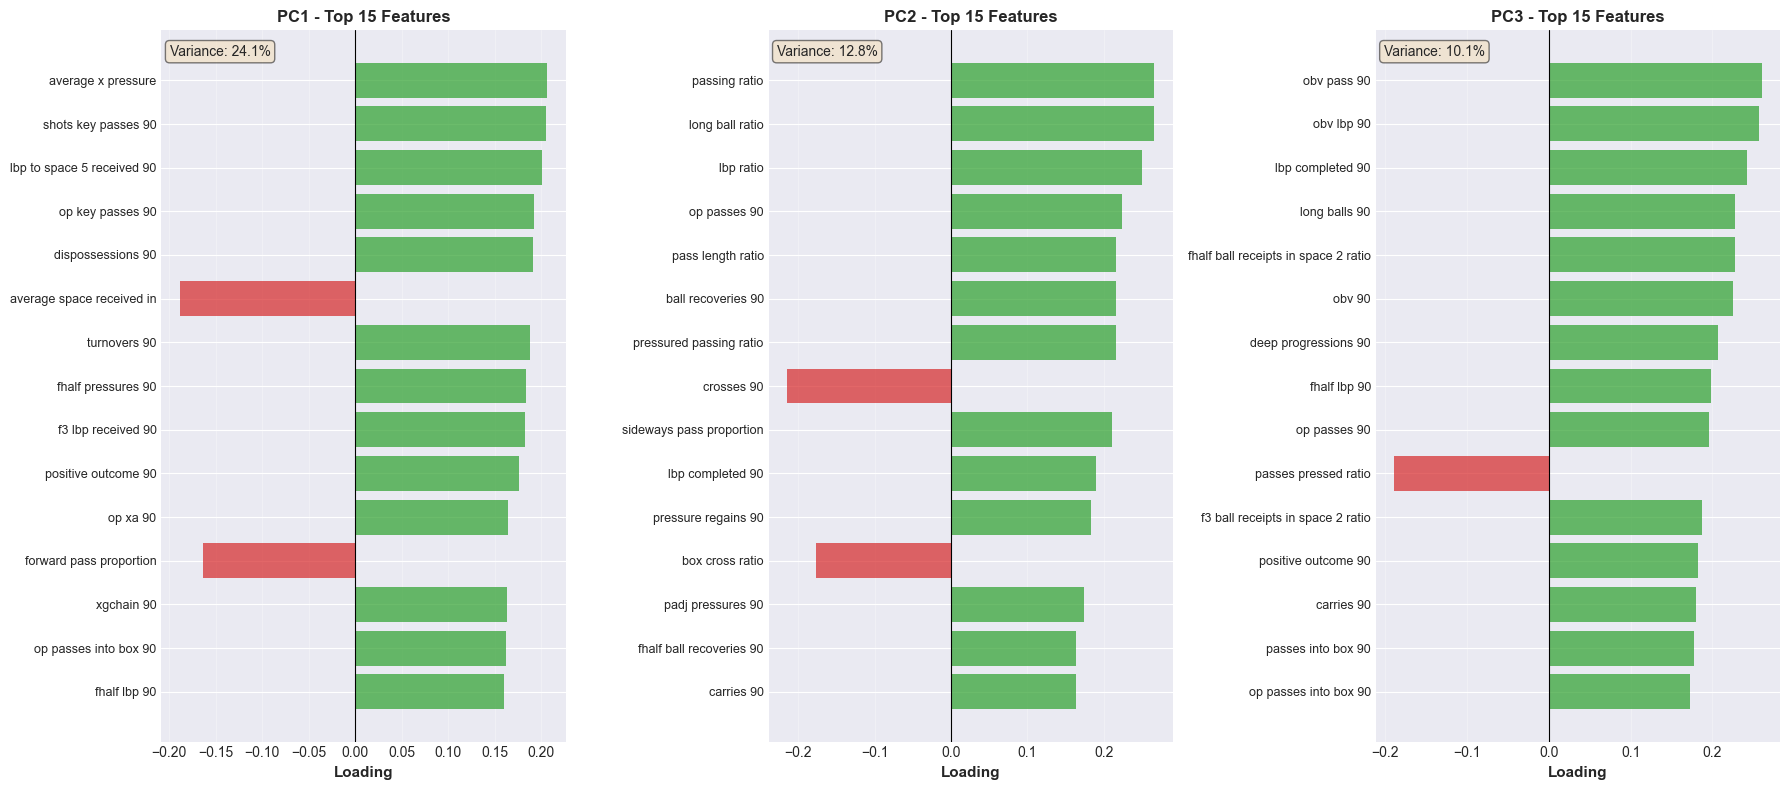

In [60]:
def plot_pc_loadings_bars(loading_results, pc_nums=[1, 2, 3], top_n=15, save_dir=None):
    """
    Create bar plots for individual PCs showing top loadings.
    """
    n_pcs = len(pc_nums)
    fig, axes = plt.subplots(1, n_pcs, figsize=(6*n_pcs, 8))
    
    if n_pcs == 1:
        axes = [axes]
    
    for idx, pc_num in enumerate(pc_nums):
        ax = axes[idx]
        pc_key = f'PC{pc_num}'
        
        # Get top features
        top_features = loading_results[pc_key].head(top_n).copy()
        top_features['short_name'] = top_features['feature'].str.replace('player_season_', '').str.replace('_', ' ')
        
        # Create bar plot
        colors = ['#d62728' if x < 0 else '#2ca02c' for x in top_features['loading']]
        ax.barh(range(len(top_features)), top_features['loading'], color=colors, alpha=0.7)
        
        # Customize
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['short_name'], fontsize=9)
        ax.invert_yaxis()
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax.set_xlabel('Loading', fontsize=11, fontweight='bold')
        ax.set_title(f'{pc_key} - Top {top_n} Features', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add variance explained
        var_explained = explained_var_ratio[pc_num-1]
        ax.text(0.02, 0.98, f'Variance: {var_explained:.1%}', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_dir:
        save_path = save_dir / f"pca_loadings_bars_PC{pc_nums[0]}-{pc_nums[-1]}.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved loading bars to {save_path}")
    
    plt.show()

# Plot first 3 PCs
log_message("\n" + "="*80)
log_message("GENERATING LOADING BAR PLOTS")
log_message("="*80)

plot_pc_loadings_bars(loading_results, pc_nums=[1, 2, 3], top_n=15, save_dir=ARTIFACT_BASE)


### Save Loadings to Artifacts


In [61]:
def save_loadings_artifacts(pca_model, feature_names, artifact_dir, n_pcs=7):
    """
    Save PCA loadings to JSON and CSV for further analysis.
    """
    log_message("\n" + "="*80)
    log_message("SAVING LOADINGS ARTIFACTS")
    log_message("="*80)
    
    # Full loadings matrix
    loadings_df = pd.DataFrame(
        pca_model.components_.T,
        index=feature_names,
        columns=[f'PC{i+1}' for i in range(len(pca_model.components_))]
    )
    
    # Save full loadings
    loadings_df.to_csv(artifact_dir / "pca_loadings_full.csv")
    log_message("✓ Saved pca_loadings_full.csv")
    
    # Save first n_pcs loadings
    loadings_subset = loadings_df.iloc[:, :n_pcs]
    loadings_subset.to_csv(artifact_dir / f"pca_loadings_first_{n_pcs}.csv")
    log_message(f"✓ Saved pca_loadings_first_{n_pcs}.csv")
    
    # Create interpretation JSON with top features per PC
    interpretation = {}
    for i in range(n_pcs):
        pc_num = i + 1
        pc_loadings = pca_model.components_[i, :]
        
        # Get indices sorted by absolute loading
        sorted_indices = np.argsort(np.abs(pc_loadings))[::-1]
        
        # Top positive and negative
        positive_features = []
        negative_features = []
        
        for idx in sorted_indices[:20]:  # Top 20
            feat_name = feature_names[idx]
            loading = float(pc_loadings[idx])
            
            if loading > 0:
                positive_features.append({"feature": feat_name, "loading": loading})
            else:
                negative_features.append({"feature": feat_name, "loading": loading})
        
        interpretation[f'PC{pc_num}'] = {
            "variance_explained": float(explained_var_ratio[i]),
            "cumulative_variance": float(cumulative_var[i]),
            "top_positive_loadings": positive_features[:10],
            "top_negative_loadings": negative_features[:10]
        }
    
    with open(artifact_dir / "pca_loadings_interpretation.json", "w", encoding='utf-8') as f:
        json.dump(interpretation, f, indent=2)
    log_message("✓ Saved pca_loadings_interpretation.json")
    
    log_message(f"\n✓ All loading artifacts saved to {artifact_dir}")

# Save loadings
save_loadings_artifacts(pca, features_final.columns.tolist(), ARTIFACT_BASE, n_pcs=7)


[INFO] 
[INFO] SAVING LOADINGS ARTIFACTS
[INFO] ================================================================================
[INFO] ✓ Saved pca_loadings_full.csv
[INFO] ✓ Saved pca_loadings_first_7.csv
[INFO] ✓ Saved pca_loadings_interpretation.json
[INFO] 
✓ All loading artifacts saved to ..\data\processed\deep_progression_artifacts


### Summary: First 7 PCs Interpretation Helper


In [62]:
def print_pc_summary(loading_results, explained_var_ratio, n_pcs=7):
    """
    Print a concise summary of what each PC represents based on loadings.
    """
    log_message("\n" + "="*80)
    log_message("PC INTERPRETATION SUMMARY")
    log_message("="*80)
    
    for i in range(n_pcs):
        pc_num = i + 1
        pc_key = f'PC{pc_num}'
        var_exp = explained_var_ratio[i]
        
        # Get top 5 positive and negative
        top_df = loading_results[pc_key].head(10)
        
        positive = top_df[top_df['loading'] > 0].head(5)
        negative = top_df[top_df['loading'] < 0].head(5)
        
        log_message(f"\n{pc_key} ({var_exp:.1%} variance):")
        log_message("-" * 60)
        
        if len(positive) > 0:
            log_message("  HIGH (+):")
            for _, row in positive.iterrows():
                short_name = row['feature'].replace('player_season_', '').replace('_', ' ')
                log_message(f"    • {short_name}")
        
        if len(negative) > 0:
            log_message("  LOW (-):")
            for _, row in negative.iterrows():
                short_name = row['feature'].replace('player_season_', '').replace('_', ' ')
                log_message(f"    • {short_name}")

# Print interpretation summary
print_pc_summary(loading_results, explained_var_ratio, n_pcs=7)


[INFO] 
[INFO] PC INTERPRETATION SUMMARY
[INFO] ================================================================================
[INFO] 
PC1 (24.1% variance):
[INFO] ------------------------------------------------------------
[INFO]   HIGH (+):
[INFO]     • average x pressure
[INFO]     • shots key passes 90
[INFO]     • lbp to space 5 received 90
[INFO]     • op key passes 90
[INFO]     • dispossessions 90
[INFO]   LOW (-):
[INFO]     • average space received in
[INFO] 
PC2 (12.8% variance):
[INFO] ------------------------------------------------------------
[INFO]   HIGH (+):
[INFO]     • passing ratio
[INFO]     • long ball ratio
[INFO]     • lbp ratio
[INFO]     • op passes 90
[INFO]     • pass length ratio
[INFO]   LOW (-):
[INFO]     • crosses 90
[INFO] 
PC3 (10.1% variance):
[INFO] ------------------------------------------------------------
[INFO]   HIGH (+):
[INFO]     • obv pass 90
[INFO]     • obv lbp 90
[INFO]     • lbp completed 90
[INFO]     • long balls 90
[INFO]     • 